In [127]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from glob import glob
import math

In [3]:
pd.set_option('display.max_columns', 80)

# import & prep df from 538

In [4]:
spi_url = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'
spi = pd.read_csv(spi_url)

In [6]:
spi = spi[spi['league'] == 'Barclays Premier League']

In [7]:
spi2 = spi

In [8]:
spi = spi.rename(columns={'team1':'team', 'team2': 'team_opp', 'spi1': 'spi', 'spi2': 'spi_opp', 'proj_score1': 'proj_score', 'proj_score2': 'proj_score_opp', 'prob1': 'prob_w', 'prob2': 'prob_l', 'importance1': 'importance', 'importance2': 'importance_opp'})

In [9]:
spi2 = spi2.rename(columns={'team2':'team', 'team1': 'team_opp', 'spi2': 'spi', 'spi1': 'spi_opp', 'proj_score2': 'proj_score', 'proj_score1': 'proj_score_opp', 'prob2': 'prob_w', 'prob1': 'prob_l', 'importance2': 'importance', 'importance1': 'importance_opp'})

In [10]:
spi = spi.append(spi2)

/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [11]:
spi = spi[['date', 'team', 'team_opp', 'spi', 'spi_opp', 'proj_score', 'proj_score_opp', 'prob_w', 'prob_l', 'probtie', 'importance', 'importance_opp']]

In [12]:
spi.team.unique()

array(['Hull City', 'Burnley', 'Southampton', 'Everton', 'Crystal Palace',
       'Middlesbrough', 'Manchester City', 'AFC Bournemouth', 'Arsenal',
       'Chelsea', 'Manchester United', 'Stoke City', 'Swansea City',
       'Tottenham Hotspur', 'West Bromwich Albion', 'Watford',
       'Leicester City', 'Sunderland', 'West Ham United', 'Liverpool',
       'Brighton and Hove Albion', 'Newcastle', 'Huddersfield Town',
       'Fulham', 'Wolverhampton', 'Cardiff City', 'Norwich City',
       'Aston Villa', 'Sheffield United', 'Leeds United'], dtype=object)

In [13]:
spi = spi.replace({'West Ham United': 'West Ham', 
    'Manchester City': 'Man City',
    'Brighton and Hove Albion': 'Brighton',
    'Cardiff City': 'Cardiff',
    'Leicester City': 'Leicester',
    'Tottenham Hotspur': 'Tottenham',
    'AFC Bournemouth': 'Bournemouth',
    'Huddersfield Town': 'Huddersfield',
    'Wolverhampton': 'Wolves',
    'Manchester United': 'Man United'})

# import and append fantasy performance data

In [1232]:
cols = ['name', 'element','kickoff_time', 'total_points',  'fixture', 'opponent_team', 'team_a_score', 'team_h_score', 'was_home', 'season', 'minutes']

I had to change the column names in 2018-19 teams.csv to make a column called "Team", to correspond with other seasons

In [1243]:
years = [('2018-19', 'ISO-8859-1'), ('2019-20', 'utf-8')]
# later realized that the 2018-19 CSV is not encoded in UTF-8, so made the above into tuples including the explicit encoding
players = pd.DataFrame()
for year, encoding in years:
    #import player-level data
    players_section = '/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/gws/merged_gw.csv'
    players_section = pd.read_csv(players_section, engine='python', encoding=encoding)
    players_section['season'] = year[:4]
    players_section = players_section[cols]
    #merge fixture data to identify teams
    fixtures = '/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/fixtures.csv'
    fixtures = pd.read_csv(fixtures, engine='python')
    fixtures = fixtures[['id', 'team_a', 'team_h']]
    players_section = players_section.merge(fixtures, how='left', left_on='fixture', right_on='id')
    #import and merge team names to align with 538 SPI data
    teams = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/teams.csv')
    teams = teams[['id', 'Team']]
    players_section = players_section.merge(teams, left_on='team_a', right_on='id')
    players_section = players_section.rename(columns={'Team': 'team_a_name'})
    players_section = players_section.merge(teams, left_on='team_h', right_on='id')
    players_section = players_section.rename(columns={'Team': 'team_h_name'})
    #import and merge player positions
    positions = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/players_raw.csv', engine='python')
    players_section = players_section.merge(positions[['id', 'element_type']], how='left', left_on='element', right_on='id')
    #append to full players dataframe
    players = players.append(players_section, ignore_index=True)

In [1244]:
players['date'] = pd.to_datetime(players['kickoff_time'])
players['date'] = players['date'].dt.strftime('%Y-%m-%d')

In [1246]:
def team_namer(was_home, home_team, away_team):
    if was_home:
        return home_team
    else:
        return away_team

In [1247]:
players['team'] = players.apply(lambda x: team_namer(x['was_home'], x['team_h_name'], x['team_a_name']), axis=1)

In [1248]:
players = players[['name', 'element','element_type','total_points', 'date', 'team', 'was_home', 'season', 'minutes']]

In [1249]:
players = players.replace({'Man Utd': 'Man United',
                'Sheffield Utd': 'Sheffield United',
                'Norwich': 'Norwich City',
                'Spurs': 'Tottenham',
})

In [1267]:
players['name'] = players['name'].str.replace('\d+', '')
players['name'] = players['name'].str.rstrip('_')
players['name'] = players['name'].str.replace('_', ' ')

In [1250]:
players = players.merge(spi, how='left', left_on=['date', 'team'], right_on=['date', 'team'])

In [1251]:
players.isnull().sum()

name               0
element            0
element_type       0
total_points       0
date               0
team               0
was_home           0
season             0
minutes            0
team_opp          59
spi               59
spi_opp           59
proj_score        59
proj_score_opp    59
prob_w            59
prob_l            59
probtie           59
importance        59
importance_opp    59
dtype: int64

Address null rows

In [1252]:
players[players.team_opp.isnull()].head()

,name,element,element_type,total_points,date,team,was_home,season,minutes,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
43660,John_Stones_207,207,2,0,2020-03-11,Man City,True,2019,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43661,David_Silva_219,219,3,0,2020-03-11,Man City,True,2019,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43662,Bukayo_Saka_541,541,3,0,2020-03-11,Arsenal,False,2019,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43663,Sead_Kolasinac_3,3,2,0,2020-03-11,Arsenal,False,2019,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43664,Bernd_Leno_14,14,1,0,2020-03-11,Arsenal,False,2019,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


the 2020-03-11 Man City v. Arsenal game was postponed to 2020-06-17 because of Covid

In [1257]:
#check that there are no other null games
players[players.team_opp.isnull()]['date'].unique()
players[players.team_opp.isnull()]['team'].unique()

array(['Man City', 'Arsenal'], dtype=object)

In [1258]:
#mke a new df for just the null game
ars_man = players[players.team_opp.isnull()]

In [1259]:
#drop the null game from the players df
players = players.dropna()
players.isnull().sum()

name              0
element           0
element_type      0
total_points      0
date              0
team              0
was_home          0
season            0
minutes           0
team_opp          0
spi               0
spi_opp           0
proj_score        0
proj_score_opp    0
prob_w            0
prob_l            0
probtie           0
importance        0
importance_opp    0
dtype: int64

In [1260]:
ars_man['date'] = '2020-06-17'

In [1261]:
ars_man = ars_man[['name', 'element','element_type','total_points', 'date', 'team', 'was_home', 'season', 'minutes']]

In [1262]:
ars_man = ars_man.merge(spi, how='left', on=['date', 'team'])

In [1263]:
ars_man.head()

,name,element,element_type,total_points,date,team,was_home,season,minutes,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
0,John_Stones_207,207,2,0,2020-06-17,Man City,True,2019,0,Arsenal,94.80,76.77,2.68,0.77,0.7727,0.0828,0.1445,0.0,40.2
1,David_Silva_219,219,3,0,2020-06-17,Man City,True,2019,0,Arsenal,94.80,76.77,2.68,0.77,0.7727,0.0828,0.1445,0.0,40.2
2,Bukayo_Saka_541,541,3,0,2020-06-17,Arsenal,False,2019,0,Man City,76.77,94.80,0.77,2.68,0.0828,0.7727,0.1445,40.2,0.0
3,Sead_Kolasinac_3,3,2,0,2020-06-17,Arsenal,False,2019,0,Man City,76.77,94.80,0.77,2.68,0.0828,0.7727,0.1445,40.2,0.0
4,Bernd_Leno_14,14,1,0,2020-06-17,Arsenal,False,2019,0,Man City,76.77,94.80,0.77,2.68,0.0828,0.7727,0.1445,40.2,0.0


In [1264]:
ars_man.isnull().sum()

name              0
element           0
element_type      0
total_points      0
date              0
team              0
was_home          0
season            0
minutes           0
team_opp          0
spi               0
spi_opp           0
proj_score        0
proj_score_opp    0
prob_w            0
prob_l            0
probtie           0
importance        0
importance_opp    0
dtype: int64

In [1265]:
players = players.append(ars_man)

# Null rows addressed, proceed with feature engineering

In [1266]:
players['spi_d'] = players['spi'] - players['spi_opp']
players['proj_score_d'] = players['proj_score'] - players['proj_score_opp']

In [1348]:
performance_history = players.groupby(['name','date'])['total_points', 'minutes'].sum().reset_index()

-> avg_performance_history looks at the player's average points over the past 5 games <-

In [1800]:
def points_history(player, date, num_games, historical_df):
    section = historical_df[(historical_df['date'] < date) & (historical_df['name'] == player)]['total_points'].tail(num_games)
    if len(section) == 0:
        return (0, 0)
    else:
        return (float(section.mean()), float(np.std(section)))

def minutes_history(player, date, num_games, historical_df):
    section = historical_df[(historical_df['date'] < date) & (historical_df['name'] == player)]['minutes'].tail(num_games)
    if len(section) == 0:
        return (0, 0)
    else:
        return (float(section.mean()), float(np.std(section)))

Add points_history over past 3, 7 & 35 games, and minutes_history for past 3 & 7 games

In [1352]:
performance_history['avg_points_3'], performance_history['std_points_3'] = performance_history.apply(lambda x: points_history(x['name'] ,x['date'], 3, performance_history), axis=1).str
performance_history['avg_points_7'], performance_history['std_points_7'] = performance_history.apply(lambda x: points_history(x['name'] ,x['date'], 7, performance_history), axis=1).str
performance_history['avg_points_35'], performance_history['std_points_35'] = performance_history.apply(lambda x: points_history(x['name'] ,x['date'], 35, performance_history), axis=1).str

In [1355]:
performance_history['avg_mins_3'], performance_history['std_mins_3'] = performance_history.apply(lambda x: minutes_history(x['name'] ,x['date'], 3, performance_history), axis=1).str
performance_history['avg_mins_7'], performance_history['std_mins_7'] = performance_history.apply(lambda x: minutes_history(x['name'] ,x['date'], 7, performance_history), axis=1).str

In [1359]:
points_to_date.head()

,name,element,season,date,total_points,avg_points_5,std_points_5,avg_points_3,std_points_3,avg_points_7,std_points_7,avg_points_35,std_points_35
0,Aaron Connolly,534,2019,2019-08-31,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aaron Connolly,534,2019,2019-09-14,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Aaron Connolly,534,2019,2019-09-21,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,Aaron Connolly,534,2019,2019-09-28,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,Aaron Connolly,534,2019,2019-10-05,13,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [1361]:
performance_history = performance_history.merge(points_to_date[['name', 'date', 'avg_points_3', 'std_points_3',
                                         'avg_points_7', 'std_points_7',
                                         'avg_points_35', 'std_points_35']],
                         on=['name', 'date'])

In [1368]:
performance_history = performance_history.drop(columns=['total_points', 'minutes'])

In [1366]:
players = players.merge(performance_history, on=['name', 'date'])

In [1367]:
players.head()

,name,element,element_type,total_points_x,date,team,was_home,season,minutes_x,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,avg_points,total_points_y,minutes_y,avg_mins_3,std_mins_3,avg_mins_7,std_mins_7,avg_points_3,std_points_3,avg_points_7,std_points_7,avg_points_35,std_points_35
0,Aaron Cresswell,402,2,0,2018-08-12,West Ham,False,2018,0,Liverpool,64.54,88.86,0.55,2.75,0.0505,0.8203,0.1292,20.7,54.8,-24.32,-2.2,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adam Lallana,250,3,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adrián San Miguel del Castillo,399,1,0,2018-08-12,West Ham,False,2018,0,Liverpool,64.54,88.86,0.55,2.75,0.0505,0.8203,0.1292,20.7,54.8,-24.32,-2.2,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alberto Moreno,240,2,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alex Oxlade-Chamberlain,248,3,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1369]:
players.head()

,name,element,element_type,total_points_x,date,team,was_home,season,minutes_x,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,avg_points,avg_mins_3,std_mins_3,avg_mins_7,std_mins_7,avg_points_3,std_points_3,avg_points_7,std_points_7,avg_points_35,std_points_35
0,Aaron Cresswell,402,2,0,2018-08-12,West Ham,False,2018,0,Liverpool,64.54,88.86,0.55,2.75,0.0505,0.8203,0.1292,20.7,54.8,-24.32,-2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Adam Lallana,250,3,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Adrián San Miguel del Castillo,399,1,0,2018-08-12,West Ham,False,2018,0,Liverpool,64.54,88.86,0.55,2.75,0.0505,0.8203,0.1292,20.7,54.8,-24.32,-2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alberto Moreno,240,2,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alex Oxlade-Chamberlain,248,3,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1370]:
injury_list = pd.DataFrame()
for season in ['2018-19', '2019-20']:
    dirs = list(glob('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+season+'/players/*/'))
    for player in dirs:
        path = player + 'gw.csv'
        gw_history = pd.read_csv(path)
        gw_history['played_more_than_20'] = pd.cut(gw_history.minutes, bins=[0, 20, 100], labels=[0,1], include_lowest=True)
        gw_history = gw_history[['element', 'kickoff_time', 'minutes', 'played_more_than_20', 'value']]
        injury_list = injury_list.append(gw_history)
injury_list['date'] = pd.to_datetime(injury_list.kickoff_time)
injury_list['date'] = injury_list['date'].dt.strftime('%Y-%m-%d')

In [1371]:
players = players.merge(injury_list[['element', 'date', 'value', 'played_more_than_20']], how='left', on=['element', 'date'])

In [1372]:
players.isnull().sum()

name                   0
element                0
element_type           0
total_points_x         0
date                   0
team                   0
was_home               0
season                 0
minutes_x              0
team_opp               0
spi                    0
spi_opp                0
proj_score             0
proj_score_opp         0
prob_w                 0
prob_l                 0
probtie                0
importance             0
importance_opp         0
spi_d                  0
proj_score_d           0
avg_points             0
avg_mins_3             0
std_mins_3             0
avg_mins_7             0
std_mins_7             0
avg_points_3           0
std_points_3           0
avg_points_7           0
std_points_7           0
avg_points_35          0
std_points_35          0
value                  2
played_more_than_20    2
dtype: int64

In [1373]:
performance_history[(performance_history['date'] < date) & (performance_history['name'] == player)]['minutes'].tail(5)

Series([], Name: minutes, dtype: int64)

In [1374]:
players[players.value.isnull()]

,name,element,element_type,total_points_x,date,team,was_home,season,minutes_x,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,avg_points,avg_mins_3,std_mins_3,avg_mins_7,std_mins_7,avg_points_3,std_points_3,avg_points_7,std_points_7,avg_points_35,std_points_35,value,played_more_than_20
27246,Cenk Tosun,146,4,0,2020-06-29,Crystal Palace,True,2019,0,Burnley,69.70,70.59,1.15,1.07,0.3711,0.3316,0.2973,0.8,0.8,-0.89,0.08,2.2,35.666667,39.041289,16.428571,30.56542,3.333333,4.027682,1.714286,3.010187,1.285714,1.905952,NaN,NaN
33069,Ryan Bennett,404,2,0,2020-01-23,Wolves,True,2019,0,Liverpool,78.63,94.30,1.10,1.86,0.2195,0.5486,0.2319,43.2,6.6,-15.67,-0.76,3.0,90.000000,0.000000,77.142857,31.49344,2.666667,2.494438,2.428571,2.381905,2.428571,2.271384,NaN,NaN


In [1375]:
players = players.dropna()

In [1376]:
players.head()

,name,element,element_type,total_points_x,date,team,was_home,season,minutes_x,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,avg_points,avg_mins_3,std_mins_3,avg_mins_7,std_mins_7,avg_points_3,std_points_3,avg_points_7,std_points_7,avg_points_35,std_points_35,value,played_more_than_20
0,Aaron Cresswell,402,2,0,2018-08-12,West Ham,False,2018,0,Liverpool,64.54,88.86,0.55,2.75,0.0505,0.8203,0.1292,20.7,54.8,-24.32,-2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0
1,Adam Lallana,250,3,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0
2,Adrián San Miguel del Castillo,399,1,0,2018-08-12,West Ham,False,2018,0,Liverpool,64.54,88.86,0.55,2.75,0.0505,0.8203,0.1292,20.7,54.8,-24.32,-2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0
3,Alberto Moreno,240,2,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,0
4,Alex Oxlade-Chamberlain,248,3,0,2018-08-12,Liverpool,True,2018,0,West Ham,88.86,64.54,2.75,0.55,0.8203,0.0505,0.1292,54.8,20.7,24.32,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0


# Begin ML Work

In [1377]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

## compare classifiers

In [1756]:
remove_cols = ['element', 'name', 'date', 'minutes', 
               'total_points', 'played_more_than_20', 
               'value', 'team', 'team_opp', 'avg_points', 'season']

In [1759]:
feature_cols = ['element_type',
 'was_home',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp',
 'spi_d',
 'proj_score_d',
 'avg_mins_3',
 'std_mins_3',
 'avg_mins_7',
 'std_mins_7',
 'avg_points_3',
 'std_points_3',
 'avg_points_7',
 'std_points_7',
 'avg_points_35',
 'std_points_35']

In [1760]:
feature_cols = [x for x in feature_cols if x not in remove_cols]

In [1761]:
feature_cols

['element_type',
 'was_home',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp',
 'spi_d',
 'proj_score_d',
 'avg_mins_3',
 'std_mins_3',
 'avg_mins_7',
 'std_mins_7',
 'avg_points_3',
 'std_points_3',
 'avg_points_7',
 'std_points_7',
 'avg_points_35',
 'std_points_35']

In [1762]:
features = players[feature_cols]
labels = players['total_points']

In [1441]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
# models.append(('SGD', SGDRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('Lasso', Lasso()))
models.append(('Elastic Net', ElasticNet()))
models.append(('Ridge', Ridge()))
models.append(('Random Forest', RandomForestClassifier()))
# evaluate each model in turn

DTR: -10.230277 (0.591768)
DTC: -9.284186 (0.492519)
Lasso: -6.380776 (0.358832)
Elastic Net: -6.380776 (0.358832)
Ridge: -5.057101 (0.354227)


/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni

Random Forest: -6.664800 (0.301888)


/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni

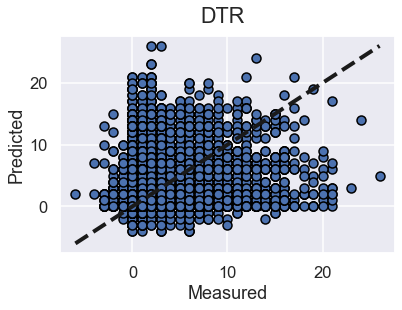

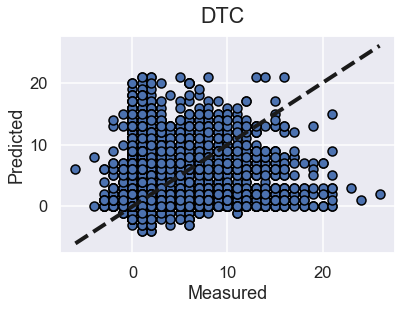

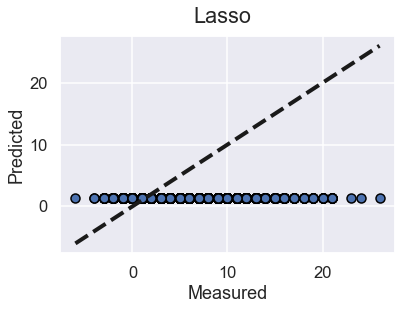

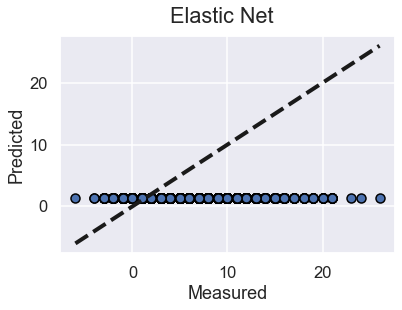

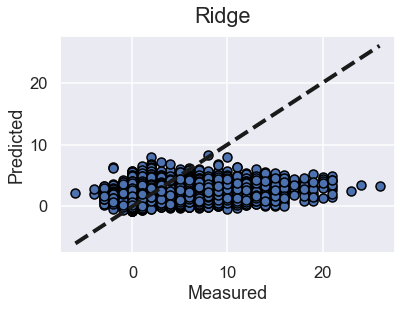

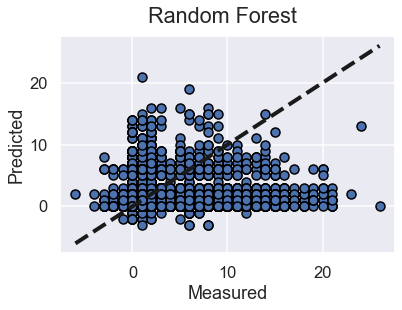

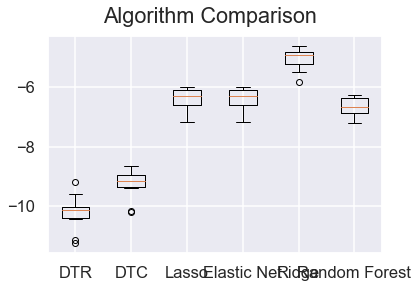

In [1443]:
#commenting out because i've already selected my model

# evaluate each model in turn
feature_sets = [features]
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
    for features in feature_sets:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        scaler = MinMaxScaler(feature_range=(0, 1))
        features = scaler.fit_transform(features)
        cv_results = model_selection.cross_val_score(model, features, labels, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        predicted = cross_val_predict(model, features, labels, cv=kfold)
        fig, ax = plt.subplots()
        ax.scatter(labels, predicted, edgecolors=(0, 0, 0))
        ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'k--', lw=4)
        fig.suptitle(name)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted') 
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## settle on Decision Tree Regressor

In [1763]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=4)

In [1764]:
#clf = RandomForestClassifier()
clf = DecisionTreeClassifier()

In [1765]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [1766]:
predictions = pd.DataFrame()
predictions['pred'] = list(clf.predict(X_test))
predictions['actual'] = list(y_test)

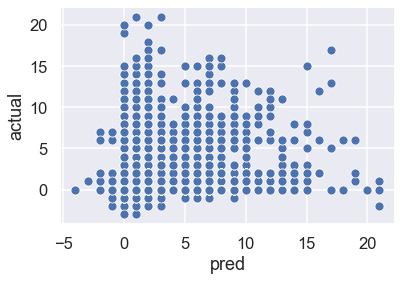

In [1767]:
sns.scatterplot(x='pred', y='actual', data=predictions)

In [1768]:
#mse of test data

mean_squared_error(predictions.actual,predictions.pred)

9.013667936365673

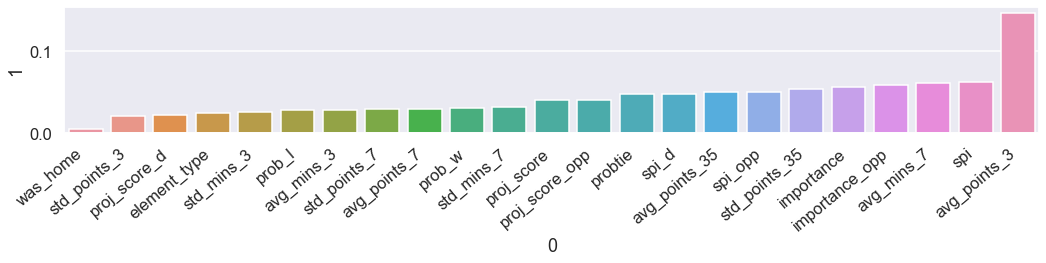

In [1769]:
## Look at feature importance in CLF

data = pd.DataFrame(zip(feature_cols, clf.feature_importances_))
data = data.sort_values(1)
plt.figure(figsize=(15,4))
ax = sns.barplot(x=0, y=1, data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [1788]:
players['clf_pred'] = list(clf.predict(features))
players['total_points'] = players.total_points.astype('float')
players['clf_pred'] = players.clf_pred.astype('float')

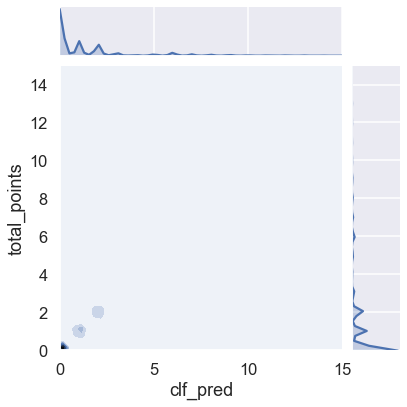

In [1789]:
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=players, x='clf_pred', y='total_points', kind='kde', xlim=(0,15), ylim=(0,15))


In [1790]:
mean_squared_error(players.clf_pred,players.total_points)

1.9829707141096597

In [1791]:
data = players.groupby('name')[['total_points', 'clf_pred']].sum()

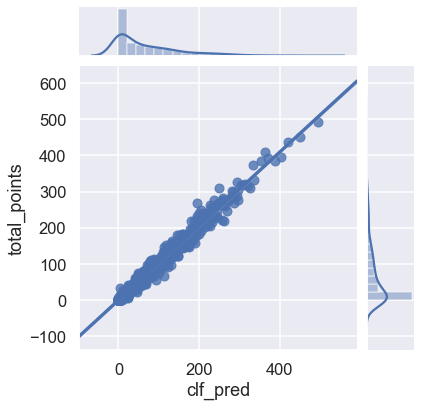

In [1792]:
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='clf_pred', y='total_points', kind='reg')


In [1793]:
mean_absolute_error(data.clf_pred, data.total_points)

6.797687861271676

18.96457576537088

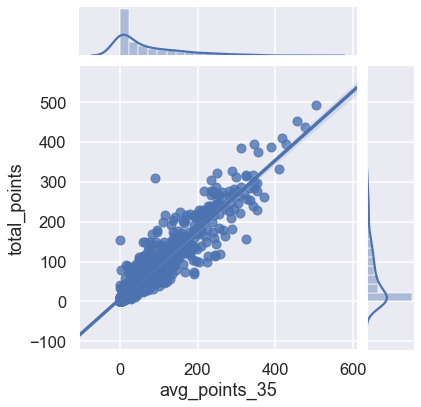

In [1487]:
#what would a season long estimate look like if we only used avg_points over the past 35 games as our indicator? not as good

data = players.groupby('name')[['total_points', 'avg_points_35']].sum()
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='avg_points_35', y='total_points', kind='reg')
mean_absolute_error(data.avg_points_35, data.total_points)

In [1794]:
players['pred_d'] = players['clf_pred'] - players['total_points']

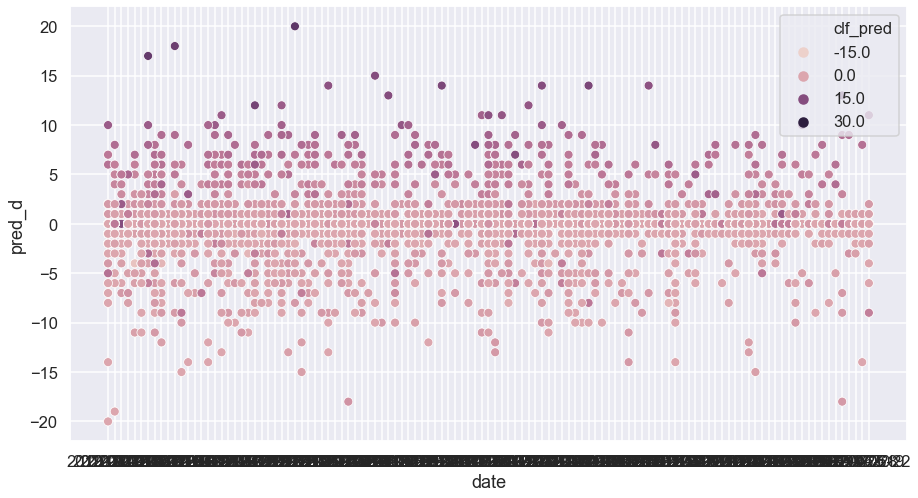

In [1795]:
data = players[['date', 'pred_d', 'clf_pred', 'season']]
data = data[data['season'] == '2019']
sns.set_style('darkgrid')
sns.set('talk')
plt.figure(figsize=(15,8))
sns.scatterplot(x='date', y='pred_d', data=data, hue='clf_pred')

# Make Predictions for 2020-2021 Season

In [1492]:
#should instead use the GW csvs, so we have data from each of the gameweeks played so far, and add SPI data only for the unplayed weeks

In [1853]:
gw_num = 5

In [1854]:
season = pd.DataFrame()
for gw in range(1,gw_num):
    week = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/2020-21/gws/gw'+str(gw)+'.csv')
    season = season.append(week)

In [1855]:
season = season[['name', 'position', 'team', 'value', 'total_points', 'minutes', 'kickoff_time']]

In [1856]:
spi.head()

,date,team,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
12,2016-08-13,Hull City,Leicester,53.57,66.81,1.16,1.24,0.3459,0.3621,0.2921,38.1,22.2
13,2016-08-13,Burnley,Swansea City,58.98,59.74,1.37,1.05,0.4482,0.2663,0.2854,36.5,29.1
14,2016-08-13,Southampton,Watford,69.49,59.33,1.91,1.05,0.5759,0.1874,0.2367,34.1,30.7
15,2016-08-13,Everton,Tottenham,68.02,73.25,1.47,1.38,0.3910,0.3401,0.2689,31.9,48.0
16,2016-08-13,Crystal Palace,West Bromwich Albion,55.19,58.66,1.35,1.14,0.4214,0.2939,0.2847,43.6,34.6


In [1857]:
spi_2020 = spi[(spi['date'] > '2020-09-01') & (spi['date'] < '2021-06-01')]

In [1858]:
for team in list(spi_2020.team.unique()):
    if not team in list(season.team):
        print(team)

West Bromwich Albion
Tottenham
Sheffield United
Leeds United
Man United


In [1859]:
season = season.replace({'Man Utd': 'Man United',
        'Spurs': 'Tottenham',
        'Sheffield Utd': 'Sheffield United',
        'West Brom': 'West Bromwich Albion',
        'Leeds': 'Leeds United'})

In [1860]:
all_players = season.sort_values('kickoff_time').drop_duplicates(subset='name', keep='last')

In [1861]:
all_players = all_players[['name', 'position', 'team', 'value']]

In [1862]:
#salah's price is off -- need better price updates
all_players.loc[all_players.name == 'Mohamed Salah', 'value'] = 123
all_players.loc[all_players.name == 'Jack Grealish', 'value'] = 71

In [1863]:
all_players[all_players['team'] == 'Wolves']

,name,position,team,value
390,Meritan Shabani,MID,Wolves,45
402,Morgan Gibbs-White,MID,Wolves,50
538,Vitor Ferreira,MID,Wolves,50
7,Adama Traoré,MID,Wolves,65
474,Rui Pedro dos Santos Patrício,GK,Wolves,55
475,Ryan Bennett,DEF,Wolves,44
550,Willy Boly,DEF,Wolves,55
482,Rúben Gonçalo Silva Nascimento Vinagre,DEF,Wolves,44
481,Rúben Diogo da Silva Neves,MID,Wolves,54
471,Romain Saïss,DEF,Wolves,51


In [1864]:
df = pd.DataFrame()
for name in all_players.name.unique():
    part = all_players[all_players['name'] == name]
    part = part.merge(spi_2020, on='team')
    df = df.append(part)

In [1865]:
set(df.team.unique()) == set(all_players.team.unique())

True

In [1866]:
# what columns do we need to add to df to match the players dataframe
for col in list(players):
    if not col in list(df):
        print(col)

element
element_type
total_points
was_home
season
minutes
spi_d
proj_score_d
avg_points
avg_mins_3
std_mins_3
avg_mins_7
std_mins_7
avg_points_3
std_points_3
avg_points_7
std_points_7
avg_points_35
std_points_35
played_more_than_20
clf_pred
pred_d


In [1867]:
df['season'] = 2020

In [1868]:
#for now, let's assume that everyone in df is healthy, and will play more than 20 minutes per game. 
df['played_more_than_20'] = 1

In [1869]:
#element_type is position, with GK = 1, Defender = 2, and so on

In [1870]:
df.position.unique()

array(['MID', 'DEF', 'GK', 'FWD'], dtype=object)

In [1871]:
df = df.replace({
    'GK': 1,
    'DEF': 2,
    'MID': 3,
    'FWD': 4
})

In [1872]:
# "Element" is the player id from the FPL site, but we're not currently using this for anything -- no need to add now

In [1873]:
#need to add whether or not the game was home
#because 'was home' was shown to have very low importance in the CLF, I'm going to mark all games as home for the time being
df['was_home'] = True

In [1874]:
#spi_d & proj_score_d is simple math, can be added using current columns
df['spi_d'] = df['spi'] - df['spi_opp']
df['proj_score_d'] = df['proj_score'] - df['proj_score_opp']

In [1875]:
#estimate importance using median importance by team
importance = df.groupby('team')['importance', 'importance_opp'].median().reset_index()

In [1876]:
df = df.merge(importance, how='left', on='team')

In [1877]:
#where 538 estimated importance (in importance_x colums), use those values
#where those values are missing, using median estimate (importance_y_columns)

df.loc[df['importance_x'].isnull(),'importance_x'] = df['importance_y']
df.loc[df['importance_opp_x'].isnull(),'importance_opp_x'] = df['importance_opp_y']

In [1878]:
df = df.drop(columns=['importance_y', 'importance_opp_y'])

In [1879]:
df = df.rename(columns={'importance_x': 'importance',
                       'importance_opp_x': 'importance_opp'})

In [1880]:
form = season.groupby(['name', 'kickoff_time'])['minutes', 'total_points'].sum().reset_index()

In [1881]:
form['date'] = pd.to_datetime(form['kickoff_time'])
form['date'] = form['date'].dt.strftime('%Y-%m-%d')

In [1882]:
form = form.drop(columns='kickoff_time')

In [1883]:
form = form.append(performance_history[list(form)])

In [1884]:
# bring oldest to top so that tail() selects most recent
form = form.sort_values('date')

In [1885]:
form[(form.name == 'Mohamed Salah') & (form.date > '2020-09-01')]

,name,minutes,total_points,date
1480,Mohamed Salah,90,20,2020-09-12
1481,Mohamed Salah,90,3,2020-09-20
1482,Mohamed Salah,90,5,2020-09-28
1483,Mohamed Salah,90,13,2020-10-04


In [1886]:
form['avg_points_3'], form['std_points_3'] = form.apply(lambda x: (0, 0) if x['date'] < '2020-09-01' else points_history(x['name'] ,x['date'], 3, form), axis=1).str
form['avg_points_7'], form['std_points_7'] = form.apply(lambda x: (0, 0) if x['date'] < '2020-09-01' else points_history(x['name'] ,x['date'], 7, form), axis=1).str
form['avg_points_35'], form['std_points_35'] = form.apply(lambda x: (0, 0) if x['date'] < '2020-09-01' else points_history(x['name'] ,x['date'], 35, form), axis=1).str
form['avg_mins_3'], form['std_mins_3'] = form.apply(lambda x: (0, 0) if x['date'] < '2020-09-01' else minutes_history(x['name'] ,x['date'], 3, form), axis=1).str
form['avg_mins_7'], form['std_mins_7'] = form.apply(lambda x: (0, 0) if x['date'] < '2020-09-01' else minutes_history(x['name'] ,x['date'], 7, form), axis=1).str

In [1887]:
#form = form.drop(columns='total_points')

calculate baseline player performance by using the first games of the current season, plus the last games of the previous season

in the training model, baseline player performance was calculated as the players average points over the past 5 games

until the 5th game of the current season, we'll supplement using an average across the last 10 games of the previous season

In [1888]:
# this merge will only include played games from this season
df_to_date = df.merge(form, on=['name', 'date'])

In [1889]:
form_most_recent = form.sort_values('date').groupby('name').tail(1)

In [1890]:
# use the most recent form and merge with all unplayed games
last_date = form_most_recent.date.tail(1).values[0]
form_most_recent = form_most_recent.drop(columns='date')
df_future = df[df['date'] > last_date].merge(form_most_recent, on='name', how='left')

In [1891]:
df = df_to_date.append(df_future, sort=False)

In [1892]:
df = df.rename(columns={'position': 'element_type'})

In [1895]:
X = df[feature_cols]

In [1896]:
y = clf.predict(X)

In [1897]:
df['clf_pred'] = y

In [1898]:
injuries = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/2020-21/soccer-injury-report.csv')

In [1899]:
list(injuries)

['Player', 'Team', 'Pos', 'Injury', 'Status', 'Est. Return']

In [1900]:
#try solving knapsack problem using predicted numbers on season 19

In [1901]:
import pulp

In [1902]:
def select_team(expected_scores, prices, positions, clubs, total_budget=99.6, sub_factor=0.2):
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
    decisions = [
        pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    captain_decisions = [
        pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    sub_decisions = [
        pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]


    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve()
    print("Total expected score = {}".format(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [1903]:
#list of names that the model should not pick -- these might be known injuries, for example

do_not_pick = list(injuries.Player)

In [1904]:
do_not_pick.extend(['Tammy Abraham', 'Tariq Lamptey', 'Martin Dubravka', 
               'Kevin De Bruyne', 'Jamaal Lascelles', 'Raheem Sterling', 'Nicolás Otamendi',
              'Eric Garcia', 'Adrián Bernabé', 'João Pedro Cavaco Cancelo', 'Claudio Bravo', 
                    'Riyad Mahrez', 'Tommy Doyle', 'Cole Palmer', 'Ilkay Gündogan'])

In [1905]:
data = df.groupby(['name', 'element_type', 'team', 'value'])['clf_pred'].sum().reset_index()
data = data.drop(index=list(data[data.name.isin(do_not_pick)].index))
expected_scores = data.clf_pred.values
prices = data.value.values / 10
positions = data.element_type.values
clubs = data.team.values
names = data.name.values
decisions, captain_decisions, sub_decisions = select_team(expected_scores, prices, positions, clubs)

/Users/andrewjpeters/opt/anaconda3/lib/python3.7/site-packages/pulp/pulp.py:1195: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Total expected score = 3150.2


In [1906]:
chosen_names = []
chosen_points = []
chosen_position = []
actual_points = []
chosen_price = []
for i in range(len(data)):
    if decisions[i].value() !=0:
        chosen_names.append(names[i])
        chosen_points.append(expected_scores[i])
        chosen_position.append(positions[i])
        chosen_price.append(prices[i])
chosen_ones = pd.DataFrame(zip(chosen_names, chosen_points, chosen_position, chosen_price), columns=['name', 'pred', 'pos', 'price'])

sub_names = []
sub_points = []
sub_position = []
actual_points = []
sub_price = []
for i in range(len(data)):
    if sub_decisions[i].value() !=0:
        sub_names.append(names[i])
        sub_points.append(expected_scores[i])
        sub_position.append(positions[i])
        sub_price.append(prices[i])
subs = pd.DataFrame(zip(sub_names, sub_points, sub_position, sub_price), columns= ['name', 'pred', 'pos', 'price'])

In [1907]:
df.groupby('name')['clf_pred'].mean().reset_index().sort_values('clf_pred', ascending=False)

,name,clf_pred
214,Ilkay Gündogan,11.945946
316,Kevin De Bruyne,11.027027
460,Riyad Mahrez,8.324324
490,Scott Dann,8.236842
520,Thiago Thiago,7.394737
...,...,...
249,Japhet Tanganga,0.000000
252,Jason Steele,0.000000
255,Jay-Roy Grot,0.000000
179,Florian Lejeune,0.000000


In [1908]:
chosen_ones.sort_values('pos')

,name,pred,pos,price
2,Kasper Schmeichel,203.0,1,5.5
5,Neco Williams,219.0,2,4.0
7,Scott Dann,313.0,2,4.5
8,Thiago Thiago,281.0,2,5.5
9,Virgil van Dijk,266.0,2,6.5
3,Mason Mount,222.0,3,6.9
4,Mohamed Salah,261.0,3,12.3
10,Willian Borges Da Silva,233.0,3,8.0
0,Gabriel Fernando de Jesus,229.0,4,9.4
1,Harry Kane,217.0,4,10.5


In [1909]:
subs.sort_values('pos')

,name,pred,pos,price
1,David de Gea,189.0,1,5.5
0,Ahmed El Mohamady,204.0,2,4.5
2,Jesse Lingard,217.0,3,5.9
3,William Smallbone,201.0,3,4.5


In [1910]:
chosen_ones.merge(players[players.name.isin(chosen_ones.name)].groupby('name')['total_points'].sum().reset_index(), on='name')

,name,pred,pos,price,total_points
0,Gabriel Fernando de Jesus,229.0,4,9.4,225.0
1,Harry Kane,217.0,4,10.5,318.0
2,Kasper Schmeichel,203.0,1,5.5,276.0
3,Mason Mount,222.0,3,6.9,137.0
4,Mohamed Salah,261.0,3,12.3,492.0
5,Neco Williams,219.0,2,4.0,14.0
6,Scott Dann,313.0,2,4.5,74.0
7,Virgil van Dijk,266.0,2,6.5,386.0
8,Willian Borges Da Silva,233.0,3,8.0,276.0


In [1914]:
subs.merge(players[players.name.isin(sub_names)].groupby('name')['total_points'].sum().reset_index(), on='name')

,name,pred,pos,price,total_points
0,Ahmed El Mohamady,204.0,2,4.5,39.0
1,David de Gea,189.0,1,5.5,143.0
2,Jesse Lingard,217.0,3,5.9,110.0
3,William Smallbone,201.0,3,4.5,24.0


In [1915]:
chosen_actual = season[season.name.isin(chosen_names)].groupby(['name', 'kickoff_time'])['total_points'].sum().reset_index()
chosen_actual.groupby('name')['total_points'].sum().reset_index()

,name,total_points
0,Gabriel Fernando de Jesus,6
1,Harry Kane,44
2,Kasper Schmeichel,12
3,Mason Mount,16
4,Mohamed Salah,41
5,Neco Williams,0
6,Patrick Bamford,30
7,Scott Dann,7
8,Thiago Thiago,7
9,Virgil van Dijk,14


In [1913]:
chosen_actual.total_points.sum()

197

In [970]:
df[df.name.isin(chosen_names)].groupby('name')['clf_pred'].sum().sort_values()

name
Rob Holding          163.666667
Adam Webster         165.500000
Virgil van Dijk      184.500000
Zack Steffen         190.000000
Kelechi Iheanacho    198.000000
Jack Grealish        211.500000
Timo Werner          216.000000
Phil Foden           227.000000
Sadio Mané           254.000000
Raúl Jiménez         258.500000
Mohamed Salah        304.000000
Name: clf_pred, dtype: float64

In [956]:
df[(df.name.isin(chosen_names))][['name', 'clf_pred', 'date']]

,name,clf_pred,date
1748,Timo Werner,13.0,2020-09-20
1749,Timo Werner,2.0,2020-10-03
1750,Timo Werner,7.0,2020-10-17
1751,Timo Werner,1.0,2020-11-07
1752,Timo Werner,4.0,2020-11-28
...,...,...,...
15613,Sadio Mané,2.0,2021-04-03
15614,Sadio Mané,14.0,2021-04-17
15615,Sadio Mané,2.0,2021-05-01
15616,Sadio Mané,9.0,2021-05-11


In [971]:
players[players.name.isin(chosen_names)].groupby(['name', 'season'])['total_points'].sum().reset_index()

,name,season,total_points
0,Adam Webster,2019,88.0
1,Jack Grealish,2019,149.0
2,Kelechi Iheanacho,2018,58.0
3,Kelechi Iheanacho,2019,64.0
4,Mohamed Salah,2018,259.0
5,Mohamed Salah,2019,233.0
6,Phil Foden,2018,25.0
7,Phil Foden,2019,69.0
8,Raúl Jiménez,2018,181.0
9,Raúl Jiménez,2019,194.0


## Changes to Implement
- Feature engineering: add short term points average (maybe past 3 games), med-term (maybe past 7), and last-season average, standard deviation of points earned over past three games
- Feature engineering: add minutes played per game over past 3 games, past 7 games, standard deviation of minutes played over past 3 games
- 'remove played_over_20_minutes' column. It's non-historical data -- I only know the answer after the game, and it's overly emphasized in the current model
- chart accuracy of prediction over time


In [1230]:
test = pd.read_csv('/Users/andrewjpeters/Documents/GitHub/fpl/data/'+year+'/gws/merged_gw.csv')

In [1231]:
test

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Aaron_Cresswell_376,0,0,7,0,1.5,376,8,5,0,1.1,9.0,2019-08-10T11:30:00Z,90,11,0,0,0,0,1,0,23399,5.0,0.0,0.0,0,0,0,0,50,True,0,1
1,Aaron_Lennon_430,0,0,3,0,0.0,430,3,0,0,0.2,2.0,2019-08-10T14:00:00Z,6,16,0,0,0,0,1,0,8105,0.0,3.0,0.0,1,0,0,0,50,True,0,1
2,Aaron_Mooy_516,0,0,0,0,0.0,516,7,0,0,0.0,0.0,2019-08-10T14:00:00Z,0,18,0,0,0,0,1,0,16261,3.0,0.0,0.0,0,0,0,0,50,False,0,1
3,Aaron_Ramsdale_494,0,0,11,0,0.0,494,2,1,0,1.0,9.8,2019-08-10T14:00:00Z,90,15,0,0,0,0,1,2,3091,1.0,1.0,0.0,2,0,0,0,45,True,0,1
4,Aaron_Wan-Bissaka_122,0,2,34,1,16.1,122,9,0,0,4.9,30.4,2019-08-11T15:30:00Z,90,6,0,0,0,0,1,0,1879259,0.0,4.0,2.0,8,0,0,0,55,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22555,Youri_Tielemans_448,0,0,11,0,37.4,448,376,1,0,6.9,12.6,2020-07-26T15:00:00Z,72,12,0,0,0,0,47,0,283764,2.0,0.0,19.0,2,-3103,1905,5008,61,True,0,47
22556,Yves_Bissouma_53,0,0,22,0,1.3,53,372,1,1,4.8,39.2,2020-07-26T15:00:00Z,72,5,0,0,0,0,47,0,2136,2.0,1.0,7.0,7,77,147,70,50,False,0,47
22557,Zech_Medley_636,0,0,0,0,0.0,636,371,0,0,0.0,0.0,2020-07-26T15:00:00Z,0,18,0,0,0,0,47,0,2496,2.0,3.0,0.0,0,153,325,172,40,True,0,47
22558,Çaglar_Söyüncü_164,0,0,0,0,0.0,164,376,0,0,0.0,0.0,2020-07-26T15:00:00Z,0,12,0,0,0,0,47,0,688011,2.0,0.0,0.0,0,-95515,165,95680,49,True,0,47
